In [1]:
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the YOLOv8 model
model = YOLO("runs/barrel/yolov8n_custom/weights/best.pt")


image 1/1 c:\Users\dk\Desktop\barrel_detection\data\val\PXL_20240705_130706817.jpg: 640x480 1 barrel, 1 tank, 87.0ms
Speed: 4.0ms preprocess, 87.0ms inference, 79.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\pose\predict


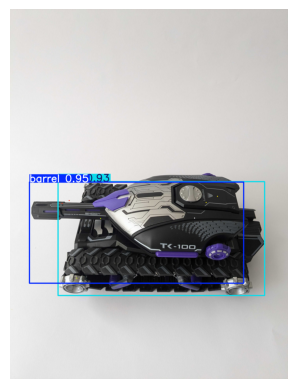

In [2]:
# Define the path or URL to the image
image_path = "data/val/PXL_20240705_130706817.jpg" # should be test image, not valid image (used for testing as there is no test image)

# Run inference on the image
results = model.predict(image_path, save=True, imgsz=640, conf=0.87) # might need to change confidence threshold

# Get the first result (assuming only one image was passed)
result = results[0]

# Visualize the detections on the image
result_image = result.plot()

# Convert the color space from BGR to RGB
rgb_image = result_image[:, :, ::-1]

# Display the image with detections
plt.imshow(rgb_image)
plt.axis('off')  # Hide axis
plt.show()

In [3]:
print(result.keypoints)

ultralytics.engine.results.Keypoints object with attributes:

conf: tensor([[0.7660, 0.7779, 0.7030, 0.6389, 0.1719],
        [0.8064, 0.8885, 0.6898, 0.8432, 0.4499]], device='cuda:0')
data: tensor([[[5.6650e+02, 2.1176e+03, 7.6603e-01],
         [2.1339e+03, 2.1085e+03, 7.7786e-01],
         [2.0071e+03, 2.2786e+03, 7.0296e-01],
         [9.8545e+02, 2.2838e+03, 6.3891e-01],
         [0.0000e+00, 0.0000e+00, 1.7195e-01]],

        [[6.4328e+02, 2.0878e+03, 8.0640e-01],
         [2.2564e+03, 2.0417e+03, 8.8845e-01],
         [2.3492e+03, 2.9434e+03, 6.8982e-01],
         [7.2695e+02, 2.9331e+03, 8.4318e-01],
         [0.0000e+00, 0.0000e+00, 4.4987e-01]]], device='cuda:0')
has_visible: True
orig_shape: (4032, 3024)
shape: torch.Size([2, 5, 3])
xy: tensor([[[ 566.5042, 2117.6362],
         [2133.9268, 2108.4871],
         [2007.1451, 2278.6345],
         [ 985.4524, 2283.8035],
         [   0.0000,    0.0000]],

        [[ 643.2753, 2087.7878],
         [2256.3528, 2041.7032],
        

In [4]:
# Extract keypoints for the barrel and the tank
keypoints_data = result.keypoints.xy.cpu().numpy()

# Assuming the first row is for the barrel and the second for the tank
barrel_keypoints = keypoints_data[0]
tank_keypoints = keypoints_data[1]

# Define the keypoints for barrel and tank
barrel_points = {
    "muzzle": barrel_keypoints[0],
    "intersection": barrel_keypoints[1]
}

tank_points = {
    "top-right": tank_keypoints[0],
    "bottom-right": tank_keypoints[1]
}

In [5]:
# Function to calculate the angle between two vectors
def calculate_angle(pt1, pt2, pt3, pt4):
    # Vector from pt1 to pt2 (barrel)
    vector1 = np.array(pt2) - np.array(pt1)
    # Vector from pt3 to pt4 (tank)
    vector2 = np.array(pt4) - np.array(pt3)

    # Calculate the angle between two vectors
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector1, unit_vector2)
    angle = np.arccos(dot_product)

    # Convert from radians to degrees
    angle = np.degrees(angle)
    return angle

In [6]:
# Calculate the rotation angle between the barrel and the tank
angle = calculate_angle(barrel_points["muzzle"], barrel_points["intersection"], tank_points["top-right"], tank_points["bottom-right"])

# Print the end barrel as a vector
print(f"Barrel vector: Barrel end (Muzzle) ({barrel_points['muzzle'][0]:.2f}, {barrel_points['muzzle'][1]:.2f}), Barrel start ({barrel_points['intersection'][0]:.2f}, {barrel_points['intersection'][1]:.2f})")

# Print the rotation angle
print(f"Estimated Rotation Angle: {angle:.2f} degrees")

# Assuming barrel_points dictionary contains the points 'muzzle' and 'intersection'
muzzle_x, muzzle_y = barrel_points['muzzle']
intersection_x, intersection_y = barrel_points['intersection']

# Calculate the orientation vector components
orientation_vector_x = muzzle_x - intersection_x
orientation_vector_y = muzzle_y - intersection_y

# Print the orientation vector
print(f"Barrel Orientation vector: ({orientation_vector_x:.2f}, {orientation_vector_y:.2f})")

Barrel vector: Barrel end (Muzzle) (566.50, 2117.64), Barrel start (2133.93, 2108.49)
Estimated Rotation Angle: 1.30 degrees
Barrel Orientation vector: (-1567.42, 9.15)
